In [35]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

import joblib
import json

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 500
pd.options.display.max_rows = 500

## Config

In [36]:
class Config:
    target_col = 'pm2_5'
    n_splits = 4
    random_state = 42
    id_col = 'id'
    missing_threshold = 0.7
    top_features = 70
    clip_threshold = 0.97
    corr_threshold = 0.9

    # Default hyperparameters
    cat_params = {
        'iterations': 1000,
        'learning_rate': 0.03,
        'depth': 6,
        'eval_metric': 'RMSE',
        'random_seed': random_state,
        'early_stopping_rounds': 250,
        'verbose': 100
    }
    lgb_params = {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': -1,
        'random_state': random_state,
        'verbosity': -1
    }
    xgb_params = {
        'n_estimators': 100,
        'learning_rate': 0.3,
        'max_depth': 6,
        'random_state': random_state,
        'objective': 'reg:squarederror'
    }
    lasso_params = {'alpha': 0.001, 'random_state': random_state}
    svr_params = {'C': 1.0, 'epsilon': 0.1}

## Load data

In [37]:
# Load data
train = pd.read_csv('dataset/Train.csv')
test = pd.read_csv('dataset/Test.csv')

In [38]:
# Remove columns with too many missing values
train = train.loc[:, train.isnull().mean() < Config.missing_threshold]
test = test.loc[:, test.isnull().mean() < Config.missing_threshold]  

In [39]:
# Create GroupKFold
def create_folds(data):
    data['folds'] = -1
    gkf = GroupKFold(n_splits=Config.n_splits)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=data['city']), start=1):
        data.loc[val_idx, 'folds'] = fold
    return data

train = create_folds(train)

### Explore data

In [40]:
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,folds
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000,3
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200,3
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741,3
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600,3
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731,3


In [41]:
# Calculate PM2.5 standard deviation per location
location_variance = train.groupby('city')[Config.target_col].std().reset_index()
location_variance.columns = ['city', 'pm2_5_std']
location_variance = location_variance.sort_values(by='pm2_5_std', ascending=False).reset_index(drop=True)
location_variance

,city,pm2_5_std
0,Lagos,52.843883
1,Nairobi,24.982218
2,Bujumbura,22.353384
3,Kampala,14.346829


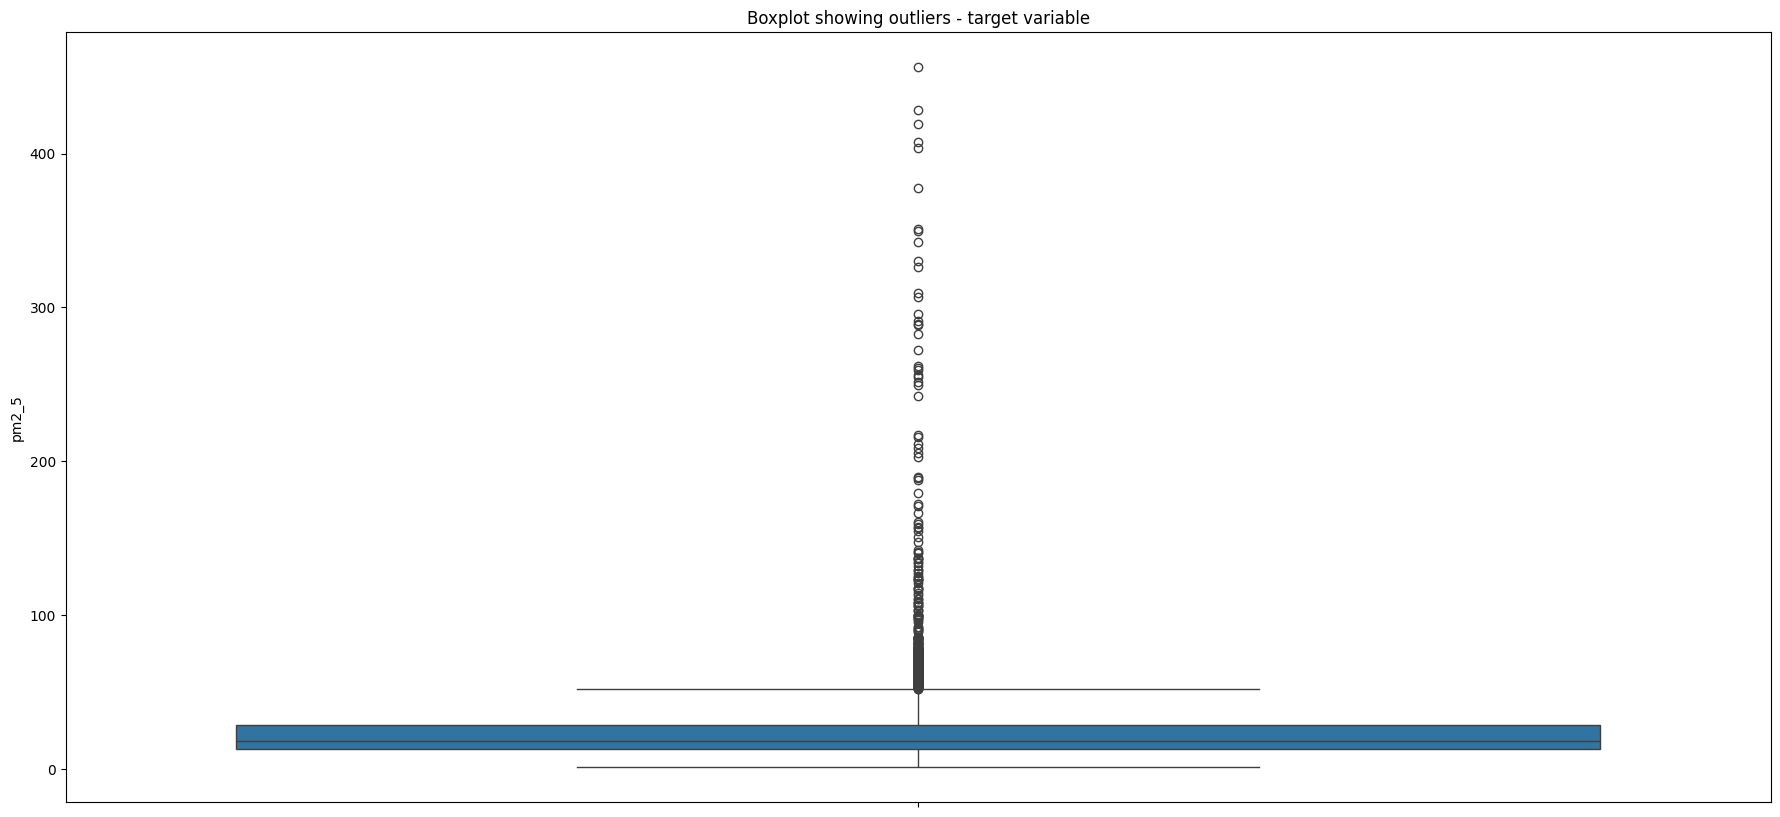

In [42]:
# Check for outliers in the target variable
plt.figure(figsize = (22, 10))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

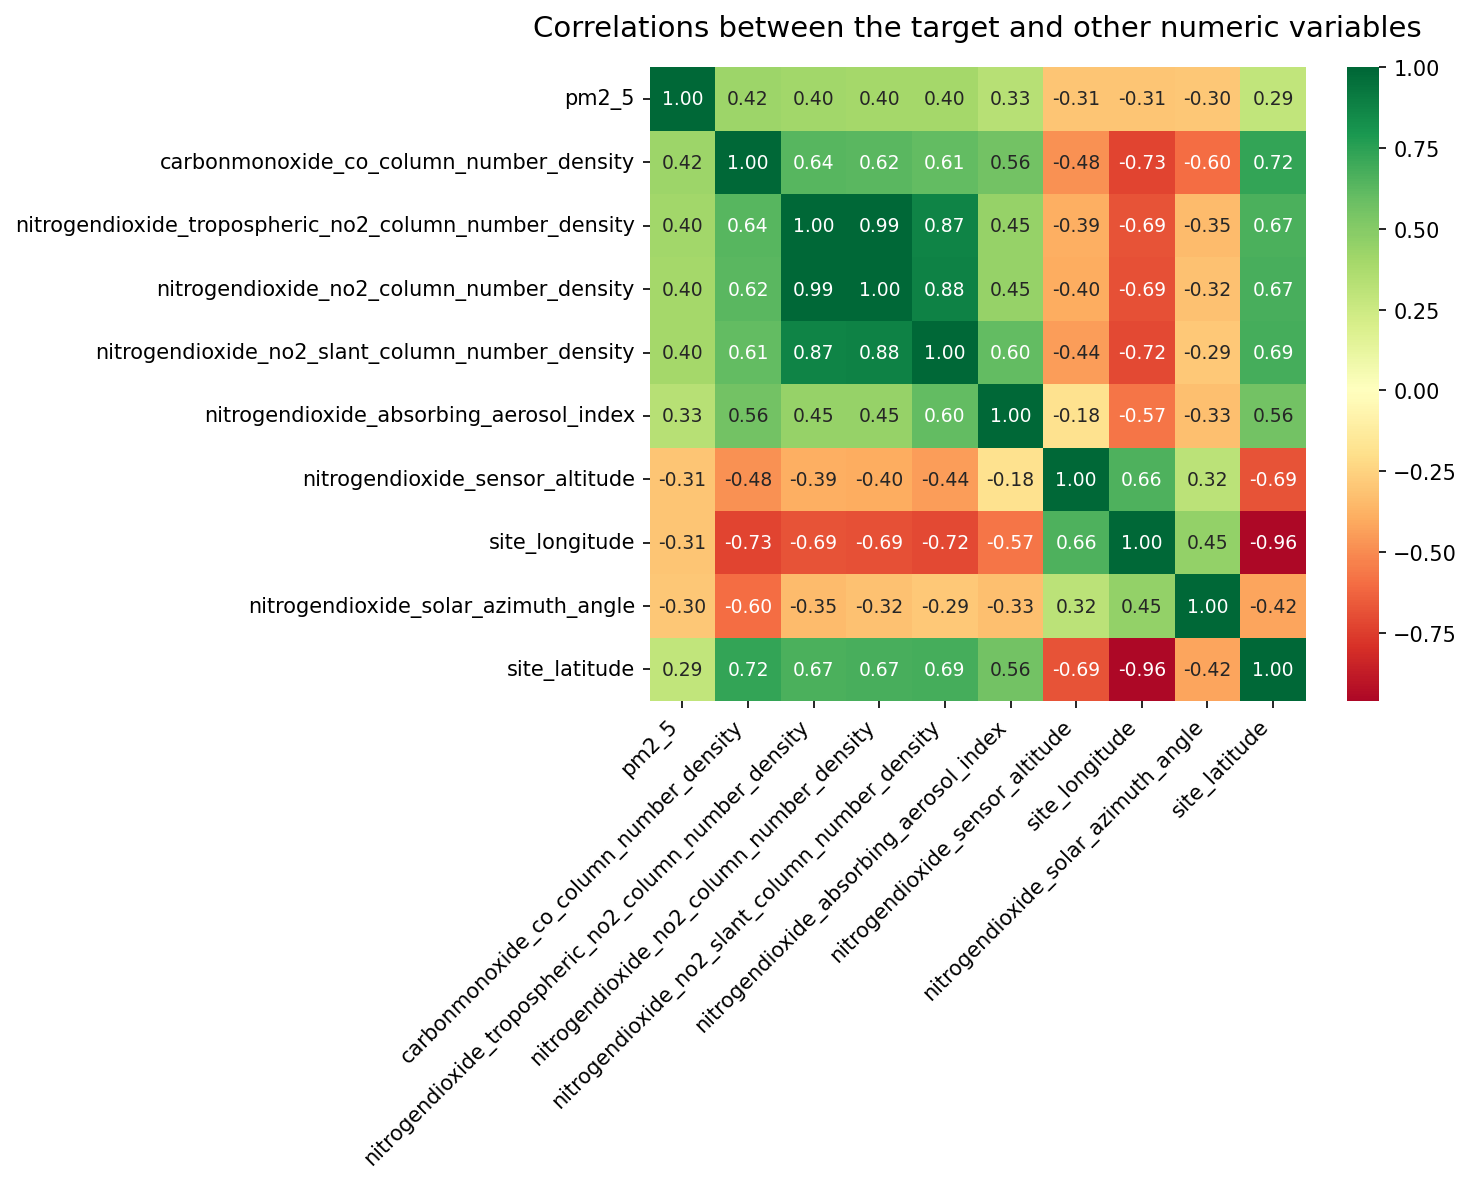

In [43]:
# Plot correlations between numerical features and target
train_num_df = train.select_dtypes(include=['number'])
top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending=False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()

plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(
    corr, cmap='RdYlGn', annot=True, center=0, fmt=".2f", 
    annot_kws={"size": 9}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlations between the target and other numeric variables', pad=15, fontdict={'size': 14})
plt.tight_layout()
plt.show()

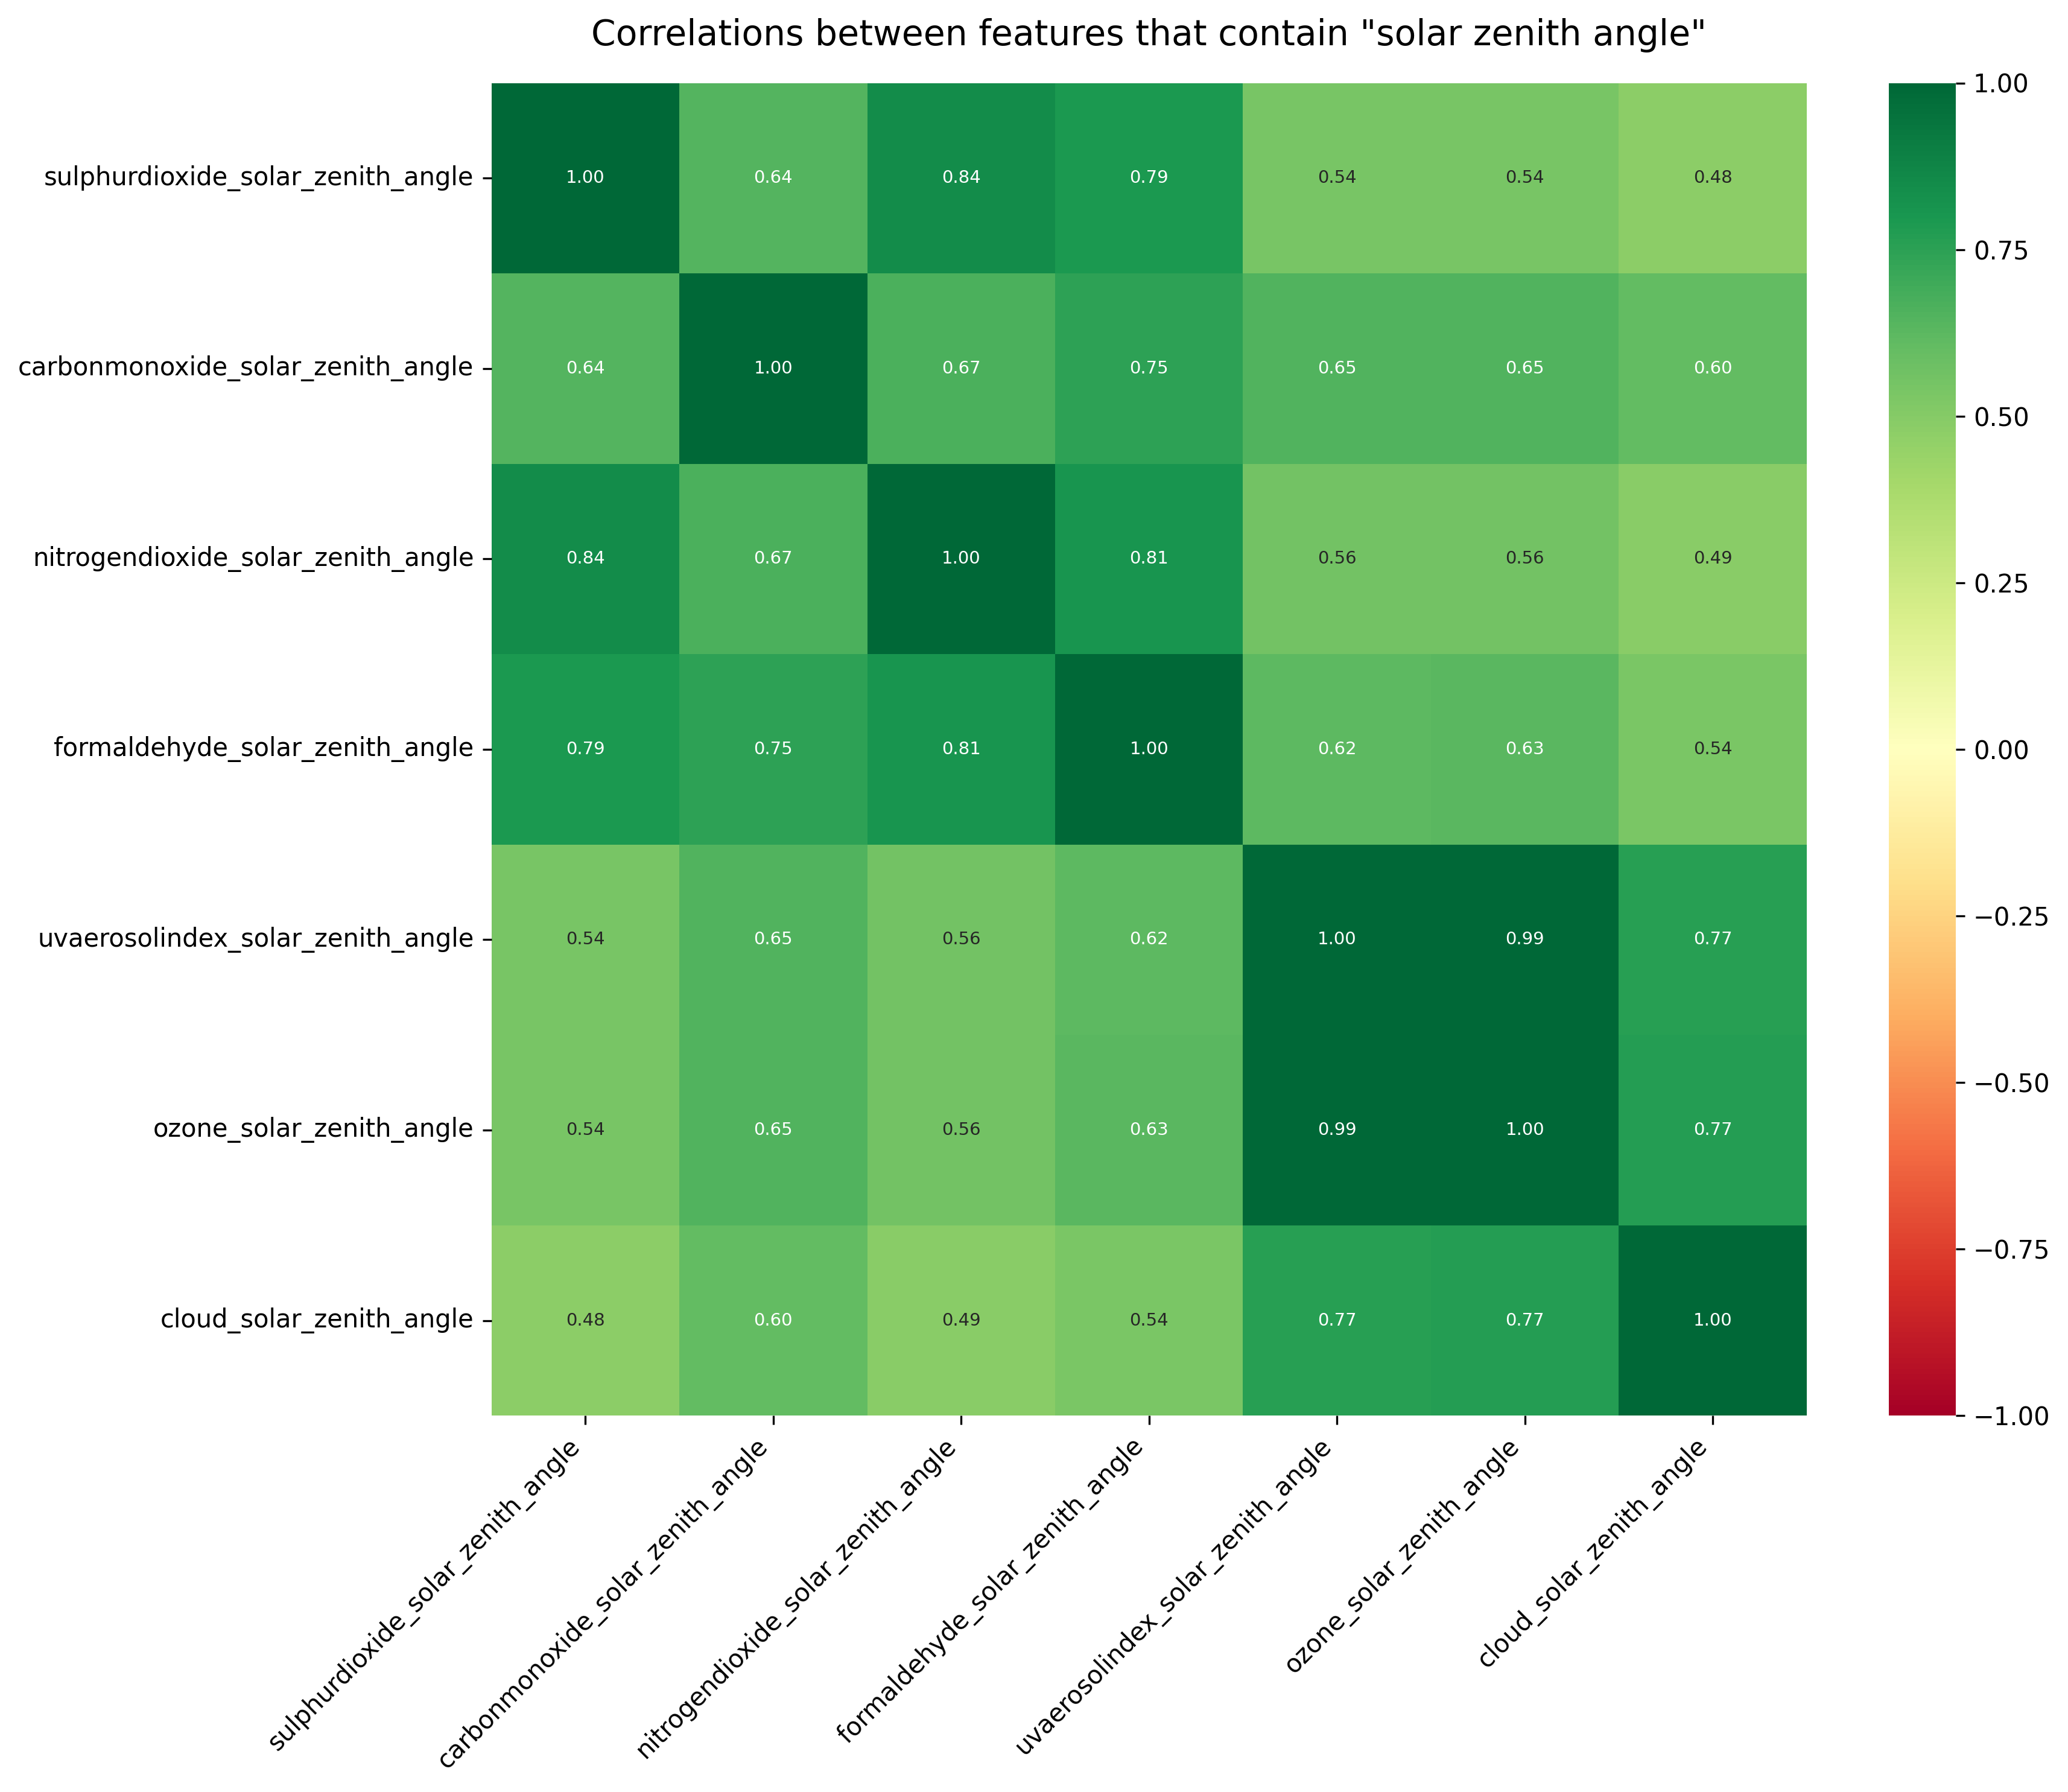

In [56]:
# Visualize correlations between features that contain 'angle' 
angle_features = [col for col in train.columns if 'solar_zenith_angle' in col]
angle_corr = train[angle_features].corr()
plt.figure(figsize=(12, 10), dpi=300)
sns.heatmap(
    angle_corr, cmap='RdYlGn', annot=True, center=0, fmt=".2f", 
    annot_kws={"size": 7}, vmin=-1, vmax=1
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlations between features that contain "solar zenith angle"', pad=15, fontdict={'size': 14})
plt.tight_layout()
plt.show()

## Feature engineering

In [44]:
# Feature engineering
def feature_engineering(train, test):
    le = LabelEncoder()
    data = pd.concat([train, test])
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')
    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in ['date', 'id', 'city', 'country']]
    print(f'Categorical columns: {categorical_cols}')

    # Date features
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.isocalendar().week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['dayofweek'].isin([5,6]).astype(int)

    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()
    numerical_cols.remove(Config.target_col)
    numerical_cols.remove('folds')
    numerical_cols.remove('hour')
    numerical_cols.remove('site_latitude')
    numerical_cols.remove('site_longitude') 
    print(f'Numerical columns: {numerical_cols}')

    # Fill in missing values by forward and backward fill within each city and location
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum() > 0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col] = (
            data.groupby(["city", "location"])[col]
                .transform(lambda x: x.ffill().bfill())
                .fillna(data[col].median())  # global fallback
            )

    # Encode categorical features
    for col in categorical_cols + ['date']:
        data[col] = le.fit_transform(data[col])

    # Split back into train and test
    train  = data[data['id'].isin(train['id'].unique())]
    test = data[data['id'].isin(test['id'].unique())]

    features = [col for col in data.columns if col not in 
                [Config.target_col, Config.id_col, 'folds', 'country', 'city', 'site_id', 'site_latitude', 'site_longitude']]
  
    return train, test, features

train, test, features = feature_engineering(train, test)

Categorical columns: ['site_id', 'location']
Numerical columns: ['date', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_amf', 'sulphurdioxide_so2_slant_column_number_density', 'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle', 'sulphurdioxide_sensor_zenith_angle', 'sulphurdioxide_solar_azimuth_angle', 'sulphurdioxide_solar_zenith_angle', 'sulphurdioxide_so2_column_number_density_15km', 'month', 'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density', 'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude', 'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_sensor_zenith_angle', 'carbonmonoxide_solar_azimuth_angle', 'carbonmonoxide_solar_zenith_angle', 'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_stratospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'nitrogendioxide_tropopau

In [45]:
test


,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,folds,location,week,day,dayofweek,is_weekend
214,id_yorywxet0a,82,5.54551,-0.21771,Accra,Ghana,233,13,-0.000134,0.758259,...,26.927189,-86.776757,25.522445,NaN,NaN,80,36,6,2,0
215,id_9rhbkh8kye,82,5.54551,-0.21771,Accra,Ghana,234,13,0.000325,1.170923,...,26.927189,-86.776757,25.522445,NaN,NaN,80,36,7,3,0
216,id_oh2pg7ik9m,82,5.54551,-0.21771,Accra,Ghana,235,13,-0.000052,0.977610,...,26.927189,-86.776757,25.522445,NaN,NaN,80,36,8,4,0
217,id_u5xtrnbshq,82,5.54551,-0.21771,Accra,Ghana,236,12,-0.000052,0.977610,...,61.874710,-90.643272,11.872849,NaN,NaN,80,36,9,5,1
218,id_pfcdhqpggy,82,5.54551,-0.21771,Accra,Ghana,237,12,0.000412,0.622374,...,61.874710,-90.643272,11.872849,NaN,NaN,80,38,20,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,id_z2s38nz9hk,106,3.88712,11.53998,Yaoundé,Cameroon,324,11,0.000009,0.654652,...,65.605360,-153.417354,15.039202,NaN,NaN,78,8,24,5,1
2779,id_c9cycuvetl,107,3.89696,11.50603,Yaoundé,Cameroon,321,12,0.000009,0.654652,...,16.577282,-125.511751,25.086502,NaN,NaN,79,8,21,2,0
2780,id_8xu1ardxni,107,3.89696,11.50603,Yaoundé,Cameroon,322,12,0.000009,0.654652,...,16.577282,-125.511751,25.086502,NaN,NaN,79,8,22,3,0
2781,id_aumy97t1iu,107,3.89696,11.50603,Yaoundé,Cameroon,323,12,0.000009,0.654652,...,16.577282,-125.511751,25.086502,NaN,NaN,79,8,23,4,0


In [46]:
train.isna().sum()


id                                                          0
site_id                                                     0
site_latitude                                               0
site_longitude                                              0
city                                                        0
country                                                     0
date                                                        0
hour                                                        0
sulphurdioxide_so2_column_number_density                    0
sulphurdioxide_so2_column_number_density_amf                0
sulphurdioxide_so2_slant_column_number_density              0
sulphurdioxide_cloud_fraction                               0
sulphurdioxide_sensor_azimuth_angle                         0
sulphurdioxide_sensor_zenith_angle                          0
sulphurdioxide_solar_azimuth_angle                          0
sulphurdioxide_solar_zenith_angle                           0
sulphurd

## Feature selection

### Embedded method

In [47]:
def top_k_feature_selection(X, y, k=Config.top_features):
    """
    Select top-k features based on CatBoost feature importance.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series or np.ndarray
        Target vector
    k : int
        Number of top features to select
    """
    model = CatBoostRegressor(**Config.cat_params)
    model.fit(X, y)

    feature_importances = model.get_feature_importance(prettified=True)
    top_features = feature_importances.head(k)['Feature Id'].tolist()

    return top_features

In [48]:
# Drop highly correlated features
def drop_highly_correlated_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f'Dropping {len(to_drop)} highly correlated features: {to_drop}')
    reduced_features = [feature for feature in X.columns.tolist() if feature not in to_drop]
    return reduced_features

## Model ensemble

In [49]:
class EnsembleModel:
    def __init__(self, top_features=30, corr_threshold=0.9, clip_threshold=0.99):
        self.top_features = top_features
        self.corr_threshold = corr_threshold
        self.clip_threshold = clip_threshold
        self.models = None
        self.reduced_features = None
        self.best_params = None

    def _clip_target(self, y):
        clip_val = np.quantile(y, self.clip_threshold)
        return np.where(y >= clip_val, clip_val, y)

    def _feature_selection(self, X, y):
        top_feats = top_k_feature_selection(X, y, k=self.top_features)
        self.reduced_features = drop_highly_correlated_features(X[top_feats], threshold=self.corr_threshold)

    def _fit_models(self, X, y, models):
        for name, model in models.items():
            model.fit(X[self.reduced_features], y)
        return models

    def cross_val_fit(self, X, y, folds, models, X_test=None):
        """Run CV to evaluate hyperparameters; returns OOF, test predictions, mean RMSE."""
        oof_preds = np.zeros(len(y))
        fold_test_preds = [] if X_test is not None else None
        fold_rmse_list = []

        unique_folds = np.unique(folds)

        for fold in unique_folds:
            train_idx = folds != fold
            val_idx = folds == fold
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            y_train_clipped = self._clip_target(y_train)

            val_preds = np.zeros((len(X_val), len(models)))
            test_preds = np.zeros((len(X_test), len(models))) if X_test is not None else None

            # Train each model
            models_fold = self._fit_models(X_train, y_train_clipped, models)
            for i, (name, model) in enumerate(models_fold.items()):
                val_preds[:, i] = model.predict(X_val[self.reduced_features])
                if X_test is not None:
                    test_preds[:, i] = model.predict(X_test[self.reduced_features])

            # Ensemble
            oof_preds[val_idx] = val_preds.mean(axis=1)
            if X_test is not None:
                fold_test_preds.append(test_preds.mean(axis=1))

            # Fold RMSE
            fold_rmse = np.sqrt(np.mean((y_val - oof_preds[val_idx])**2))
            fold_rmse_list.append(fold_rmse)

        mean_rmse = np.mean(fold_rmse_list)
        final_test_preds = np.mean(fold_test_preds, axis=0) if X_test is not None else None
        return oof_preds, final_test_preds, mean_rmse

    def fit_final(self, X, y, models):
        """Train final ensemble on full training data after hyperparameter selection."""
        y_clipped = self._clip_target(y)
        self._feature_selection(X, y_clipped)
        self.models = self._fit_models(X, y_clipped, models)

    def predict(self, X):
        """Predict using the ensemble (mean of all models)."""
        test_preds = np.zeros((len(X), len(self.models)))
        for i, (name, model) in enumerate(self.models.items()):
            test_preds[:, i] = model.predict(X[self.reduced_features])
        return np.mean(test_preds, axis=1)

ensemble = EnsembleModel(top_features=Config.top_features,
                         corr_threshold=Config.corr_threshold,
                         clip_threshold=Config.clip_threshold)
ensemble._feature_selection(train[features], train[Config.target_col].values)

0:	learn: 24.5900342	total: 9.9ms	remaining: 9.89s
100:	learn: 17.1515336	total: 229ms	remaining: 2.04s
200:	learn: 15.2004034	total: 455ms	remaining: 1.81s
300:	learn: 13.7002700	total: 685ms	remaining: 1.59s
400:	learn: 12.2034103	total: 915ms	remaining: 1.37s
500:	learn: 11.1726742	total: 1.13s	remaining: 1.13s
600:	learn: 10.3744593	total: 1.36s	remaining: 905ms
700:	learn: 9.7283556	total: 1.63s	remaining: 695ms
800:	learn: 9.1771807	total: 1.86s	remaining: 463ms
900:	learn: 8.6822640	total: 2.13s	remaining: 234ms
999:	learn: 8.3147238	total: 2.37s	remaining: 0us
Dropping 19 highly correlated features: ['nitrogendioxide_no2_column_number_density', 'nitrogendioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'cloud_solar_azimuth_angle', 'month', 'sulphurdioxide_so2_slant_column_number_density', 'carbonmonoxide_solar_azimuth_angle', 'cloud_cloud_base_height', 'formaldehyde_solar_azimuth_angle', 'sulphurdioxide_solar_azimuth_angle', 'cloud_cloud_top_pressure', 'sulphurdioxide_

## Cross-validation with GroupKFold for hyperparameter search

In [50]:
def objective(trial):
    models = {
        "cat": CatBoostRegressor(
            iterations=1000,
            learning_rate=trial.suggest_float('cat_lr', 0.01, 0.1, log=True),
            depth=trial.suggest_int('cat_depth', 4, 10),
            random_seed=Config.random_state,
            verbose=0,
            early_stopping_rounds=250
        ),
        "lgb": LGBMRegressor(
            n_estimators=100,
            learning_rate=trial.suggest_float('lgb_lr', 0.01, 0.1, log=True),
            max_depth=trial.suggest_int('lgb_depth', 3, 12),
            random_state=Config.random_state,
            verbosity=-1
        ),
        "xgb": XGBRegressor(
            n_estimators=100,
            learning_rate=trial.suggest_float('xgb_lr', 0.01, 0.1, log=True),
            max_depth=trial.suggest_int('xgb_depth', 3, 12),
            random_state=Config.random_state,
            objective='reg:squarederror'
        ),
        "lasso": Lasso(alpha=trial.suggest_float('lasso_alpha', 1e-4, 1.0, log=True),
                       random_state=Config.random_state),
        "svr": SVR(
            C=trial.suggest_float('svr_C', 0.1, 10.0, log=True),
            epsilon=trial.suggest_float('svr_eps', 0.01, 1.0, log=True)
        )
    }

    _, _, mean_rmse = ensemble.cross_val_fit(
        train[features],
        train[Config.target_col].values,
        folds=train['folds'].values,
        models=models
    )
        
    return mean_rmse

# Optimize hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-09-30 15:59:41,794] A new study created in memory with name: no-name-91b7386a-6090-459e-8e79-59a6e919b1ed
[I 2025-09-30 16:00:25,442] Trial 0 finished with value: 28.107810166049 and parameters: {'cat_lr': 0.06706791593109614, 'cat_depth': 9, 'lgb_lr': 0.09176215428184308, 'lgb_depth': 6, 'xgb_lr': 0.06752834913497954, 'xgb_depth': 4, 'lasso_alpha': 0.00017260348118506671, 'svr_C': 0.3692559175274507, 'svr_eps': 0.014026871614292473}. Best is trial 0 with value: 28.107810166049.
[I 2025-09-30 16:00:41,985] Trial 1 finished with value: 28.2629817584344 and parameters: {'cat_lr': 0.03767476782264887, 'cat_depth': 6, 'lgb_lr': 0.022158548885765055, 'lgb_depth': 11, 'xgb_lr': 0.010338412409175792, 'xgb_depth': 9, 'lasso_alpha': 0.0007535494293689558, 'svr_C': 1.1232236735222993, 'svr_eps': 0.4889861200876556}. Best is trial 0 with value: 28.107810166049.
[W 2025-09-30 16:00:50,502] Trial 2 failed with parameters: {'cat_lr': 0.049624927778103796, 'cat_depth': 4, 'lgb_lr': 0.06940713

KeyboardInterrupt: 

## Final train on full data and predict on test set

In [ ]:
# Extract best hyperparameters
best_params = study.best_params
Config.cat_params['learning_rate'] = best_params['cat_lr']
Config.cat_params['depth'] = best_params['cat_depth']
Config.lgb_params['learning_rate'] = best_params['lgb_lr']
Config.lgb_params['max_depth'] = best_params['lgb_depth']
Config.xgb_params['learning_rate'] = best_params['xgb_lr']   
Config.xgb_params['max_depth'] = best_params['xgb_depth']
Config.lasso_params['alpha'] = best_params['lasso_alpha']
Config.svr_params['C'] = best_params['svr_C']
Config.svr_params['epsilon'] = best_params['svr_eps']

# Define final models with best hyperparameters
best_models = {
    "cat": CatBoostRegressor(**Config.cat_params),
    "lgb": LGBMRegressor(**Config.lgb_params),
    "xgb": XGBRegressor(**Config.xgb_params),
    "lasso": Lasso(**Config.lasso_params),
    "svr": SVR(**Config.svr_params)
}

ensemble.fit_final(train[features], train[Config.target_col].values, best_models)
final_test_preds = ensemble.predict(test[features])

In [ ]:
# Save best models
folder_name = f"./weights/{study.best_value:.2f}"  # keep 4 decimal places
os.makedirs(folder_name, exist_ok=True)

# Save models
for name, model in best_models.items():
    joblib.dump(model, f"{folder_name}/best_model_{name}.pkl")

# Save reduced feature list
with open(f"{folder_name}/reduced_features.json", "w") as f:
    json.dump(ensemble.reduced_features, f)

In [ ]:
# Plot feature importance from final CatBoost model
plt.figure(figsize=(20, 16))
feature_importances_df = pd.DataFrame(best_models['cat'].feature_importances_, columns=['Importances'])
feature_importances_df['Feature'] = ensemble.reduced_features
sns.barplot(x='Importances', y='Feature', data=feature_importances_df.sort_values(by=['Importances'], ascending=False).head(20))
plt.title('Top 20 Feature Importances')
plt.show()

## Prepare test submission

In [ ]:
def prepare_submission(test, best_test_pred, save_path='output/submission.csv'):
    """Prepare submission file."""
    test[Config.target_col] = best_test_pred
    submission = test[[Config.id_col, Config.target_col]]
    submission.to_csv(save_path, index=False)
    submission.head()
    
prepare_submission(test, final_test_preds)

### Load best models and save submission

In [ ]:
def load_and_predict(test, rmse=27.84, model_names=None):
    """
    Load best models, make predictions on test set, and ensemble them.

    Args:
        test (pd.DataFrame): Test dataset.
        rmse (float): RMSE value to locate model folder.
        model_names (list): List of model names to load. Defaults to ['cat', 'lgb', 'xgb', 'lasso', 'svr'].

    Returns:
        np.ndarray: Ensemble predictions for the test set.
    """
    if model_names is None:
        model_names = ['cat', 'lgb', 'xgb', 'lasso', 'svr']

    # Load models
    folder_name = f"./weights/{rmse:.2f}"
    models = {name: joblib.load(f"{folder_name}/best_model_{name}.pkl") for name in model_names}

    # Load reduced features
    with open(f"{folder_name}/reduced_features.json", "r") as f:
        features = json.load(f)

    # Prepare test predictions
    test_preds = np.zeros((len(test), len(models)))

    # Predict
    for i, (name, model) in enumerate(models.items()):
        test_preds[:, i] = model.predict(test[features])

    # Ensemble with equal weights
    final_test_pred = np.mean(test_preds, axis=1)

    return final_test_pred

final_test_preds = load_and_predict(test, rmse=27.78)

# Save final submission
# prepare_submission(test, final_test_preds)

In [ ]:
# Post processing by multiply with a scale factor
scale_factor = 1  # Adjust this factor based on validation results
final_test_preds_scaled = final_test_preds * scale_factor
prepare_submission(test, final_test_preds_scaled)